Reference: https://www.kaggle.com/code/bguberfain/openai-clip-with-train

In [1]:
%%capture

import sys
!cp -r ../input/openai-clip/CLIP/CLIP-main /tmp/

!gzip -c /tmp/CLIP-main/clip/bpe_simple_vocab_16e6.txt > /tmp/CLIP-main/clip/bpe_simple_vocab_16e6.txt.gz
sys.path.append('/tmp/CLIP-main')

!pip install ../input/openai-clip/ftfy-5.9/ftfy-5.9 \
             ../input/openai-clip/torch-1.7.1+cu110-cp37-cp37m-linux_x86_64.whl \
             ../input/openai-clip/torchvision-0.8.2+cu110-cp37-cp37m-linux_x86_64.whl \
             ../input/faiss-163/faiss_gpu-1.6.3-cp37-cp37m-manylinux2010_x86_64.whl

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import Sampler
import clip
from clip.simple_tokenizer import SimpleTokenizer
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import re
import faiss  # for similarity search and clustering of dense vectors
import matplotlib.pyplot as plt
from triplet_loss import TripletLoss

%matplotlib inline

In [3]:
df_test = pd.read_csv('../input/shopee-product-matching/test.csv', index_col='posting_id')

RUN_ON_TRAIN = len(df_test) == 3

### Utility classes and functions

In [4]:
_tokenizer = SimpleTokenizer()

# Copied from https://github.com/openai/CLIP/blob/beba48f35392a73c6c47ae67ddffced81ad1916d/clip/clip.py#L164
# but with relaxed exception
def tokenize(texts, context_length: int = 77) -> torch.LongTensor:
    if isinstance(texts, str):
        texts = [texts]

    sot_token = _tokenizer.encoder["<|startoftext|>"]
    eot_token = _tokenizer.encoder["<|endoftext|>"]
    all_tokens = [[sot_token] + _tokenizer.encode(text) + [eot_token] for text in texts]
    result = torch.zeros(len(all_tokens), context_length, dtype=torch.long)

    for i, tokens in enumerate(all_tokens):
        n = min(len(tokens), context_length)
        result[i, :n] = torch.tensor(tokens)[:n]
        if len(tokens) > context_length:
            result[i, -1] = tokens[-1]

    return result

In [5]:
# Remove EMOJI
RE_EMOJI = re.compile(r"\\x[A-Za-z0-9./]+", flags=re.UNICODE)

def strip_emoji(text):
    return RE_EMOJI.sub(r'', text)

In [6]:
class RollingMean():
    def __init__(self):
        self.n = 0
        self.mean = 0
        
    def update(self, value):
        self.mean = (self.mean * self.n + value) / (self.n+1)
        self.n += 1
        
    def result(self):
        return self.mean

### Sampler and dataset

In [7]:
# to make sure that in every batch, two samples of the same group are always present
# which is required by Triplet SemiHardLoss (https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py)

class SameGroupSampler(Sampler):
    def __init__(self, df ,ds):
        super().__init__(ds)
        
        # Create a dictionary of posting_id -> index in dataset
        self.index_to_position = dict(zip(df.index, range(len(df))))
        
        # Create a Series of label_group -> set(posting_id)
        self.label_group = df.reset_index().groupby('label_group')['posting_id'].apply(set).map(sorted).map(np.array)

    def __len__(self):
        return len(self.label_group)
        
    def __iter__(self):
        for _ in range(len(self)):
            # Sample one label_group
            label_group_sample = self.label_group.sample(1).iloc[0]
            
            # Sample two posting_id's
            sample1, sample2 = np.random.choice(label_group_sample, 2, replace=False)
            
            yield self.index_to_position[sample1]
            yield self.index_to_position[sample2]            

In [8]:
class MyDataset(Dataset):
    def __init__(self, df, images_path):
        super().__init__()
        self.df = df
        self.images_path = images_path
        self.has_target = ('label_group' in df)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        image = preprocess(Image.open(self.images_path / row['image']))
        text = tokenize([strip_emoji(row['title'])])[0]
        
        if self.has_target:
            return image, text, row['label_group']
        else:
            return image, text, 0

## Finetune CLIP on train data

Here we use the triplet loss principe to ajust CLIP:

![Triplet loss](https://user-images.githubusercontent.com/18154355/61485418-1cbb1f00-a96f-11e9-8de8-3c46eef5a7dc.png)

In [9]:
# Load CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("../input/openai-clip/ViT-B-32.pt", device=device, jit=False)

# Get embedding size
embed_dim = model.text_projection.shape[1]
embed_dim

512

In [10]:
# Load train data
train_images_path = Path('../input/shopee-product-matching/train_images')

df_train = pd.read_csv('../input/shopee-product-matching/train.csv', index_col='posting_id')

dstrain = MyDataset(df_train, train_images_path)
dltrain = DataLoader(dstrain, batch_size=128, num_workers=2, sampler=SameGroupSampler(df_train, dstrain))

In [11]:
# a demonstration of the sampler result
for i, d in enumerate(dltrain):
    if i > 0:
        break
    label_group = d[2].numpy()
    
    print("label_group in one batch:")
    for idx in range(0, 128, 2):
        print(label_group[idx : idx+2])

label_group in one batch:
[2209994116 2209994116]
[1287470540 1287470540]
[2885752806 2885752806]
[3170502392 3170502392]
[2724853036 2724853036]
[3727750590 3727750590]
[430501350 430501350]
[4008024672 4008024672]
[2157423883 2157423883]
[1198315635 1198315635]
[3763036039 3763036039]
[3661312991 3661312991]
[1779408602 1779408602]
[847854913 847854913]
[4103124262 4103124262]
[3136889376 3136889376]
[1461239259 1461239259]
[3713968593 3713968593]
[1947359892 1947359892]
[3784808595 3784808595]
[1682488100 1682488100]
[3566522501 3566522501]
[4114962237 4114962237]
[1542179482 1542179482]
[2779526092 2779526092]
[3242646592 3242646592]
[1850007430 1850007430]
[2091479370 2091479370]
[3678349373 3678349373]
[2384596174 2384596174]
[3699648654 3699648654]
[3424584900 3424584900]
[3925954645 3925954645]
[1571631297 1571631297]
[4086252188 4086252188]
[3156823611 3156823611]
[2898255895 2898255895]
[705729218 705729218]
[3671283483 3671283483]
[3596008611 3596008611]
[4203412919 42034129

In [12]:
n_epochs = 1

optim = torch.optim.AdamW(model.parameters(), lr=1e-4, eps=1e-8, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, 1e-2, total_steps=n_epochs * (2*len(dltrain)-1),
                                               base_momentum=0.0, max_momentum=0.5, pct_start=0.1, div_factor=1e2, final_div_factor=1e4)
criterion = TripletLoss(device)

In [13]:
for epoch in range(n_epochs):
    with tqdm(total=2*len(dltrain)-1) as bar:
        loss_mean = RollingMean()
        for images, texts, targets in dltrain:
            targets = targets.to(device)
            
            # Generate train and text features
            images_features = model.encode_image(images.to(device))
            texts_features = model.encode_text(texts.to(device))

            optim.zero_grad()

            # Join train and test features
            features = torch.hstack([images_features, texts_features])
            
            # L2-normalize features
            features = features / features.norm(2, dim=1, keepdim=True)

            # Apply Triplet SemiHardLoss
            loss = criterion(features, targets)

            loss.backward()
            optim.step()
            scheduler.step()

            # Update metric and progress bar
            loss_mean.update(loss.item())
            bar.update()
            bar.set_description('{:.4f}'.format(loss_mean.result()))

  0%|          | 0/173 [00:00<?, ?it/s]

Generate features using finetuned CLIP and perform a similiarity search to find the closest matches under a threshold:

In [14]:
def find_similarities_and_indexes(df, images_path, top_n=100, features_file=None):
    # Create pytorch Dataset/DataLoader
    ds = MyDataset(df, images_path)
    dl = DataLoader(ds, batch_size=32, shuffle=False, num_workers=2)

    # Allocate memory for features
    features = np.empty((len(df), 2*embed_dim), dtype=np.float32)

    i = 0
    for images, texts, _ in tqdm(dl):
        n = len(images)
        with torch.no_grad():
            # Generate image and text features
            images_features = model.encode_image(images.to(device))
            texts_features = model.encode_text(texts.to(device))

        # Concat features
        features[i:i+n, :embed_dim] = images_features.cpu()
        features[i:i+n, embed_dim:] = texts_features.cpu()

        i += n

    # Option to save these features (may be usefull to tune cut value)
    if features_file is not None:
        np.save(features_file, features)

    # l2-normalize
    features /= np.linalg.norm(features, 2, axis=1, keepdims=True)

    # Create index
    index = faiss.IndexFlatIP(2*embed_dim)
    index.add(features)

    # Search index
    return index.search(features, top_n)

    # TODO: try range_search
    # lims, similarities, indexes = index_test.range_search(test_features, GROUP_CUT)

  0%|          | 0/1071 [00:00<?, ?it/s]

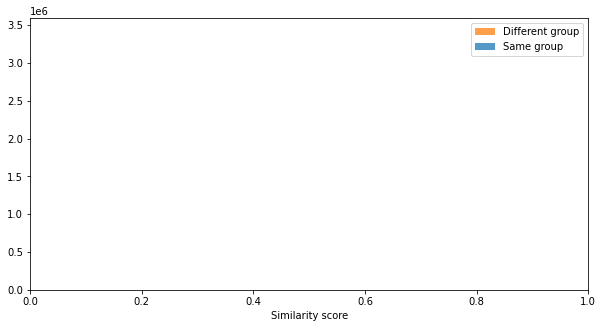

In [15]:
if RUN_ON_TRAIN:
    # Perform search of similiar items
    similarities, indexes = find_similarities_and_indexes(df_train, train_images_path, features_file='features-no-norm.npy')
    
    # `similarities` will have shape (n, 100) and will have the similarites scores for closest matches.
    # `indexes` will have shape (n, 100) and have the index closest matches.
    # Both arrays are aligned.

    # Convert index to groups, will have shape (n, 100)
    found_groups = df_train['label_group'].values[indexes]

    # Check if matches are from same group. Will create a boolean vector of (n, 100)
    is_same_group = (found_groups == df_train['label_group'].values[:, np.newaxis])

    # Plot similarities score from same group and different groups
    plt.figure(figsize=(10, 5))
    plt.hist([similarities[is_same_group], similarities[~is_same_group]], density=False, bins=51,
         label=['Same group', 'Different group'], histtype='stepfilled', alpha=0.75)
    plt.xlim(0, 1)
    plt.xlabel('Similarity score')
    plt.legend();

Move the `cut_value` to find optimal F1-score.

In [16]:
# SRC: https://www.kaggle.com/c/shopee-product-matching/discussion/224782#1233338
# With some adaptation
def row_wise_f1_score(y_true, y_pred):
    tp = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    fp = y_pred.apply(lambda x: len(x)).values - tp
    fn = y_true.apply(lambda x: len(x)).values - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    return f1


def calc_score(cut_value):
    # Apply cutoff of similarities
    groups_are_same = (similarities > cut_value)

    # Build results
    results = []
    for i, (group_is_same, index_result) in enumerate(zip(groups_are_same, indexes)):
        row_results = df_train.index[index_result[group_is_same]]

        # Keep found matches as a `set`
        results.append(set(row_results))

    df_results = pd.Series(results, index=df_answer.index)
    
    # Evaluate results
    return row_wise_f1_score(df_answer, df_results).mean()

  0%|          | 0/51 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Best cutoff is 0.50 with expected F1 score of nan


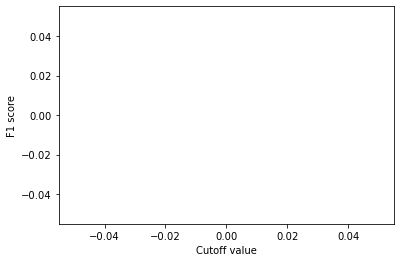

In [17]:
if RUN_ON_TRAIN:
    # Create answer dataframe. This will have posting_id on index and a set of label_group as values 
    groups = df_train.reset_index().groupby('label_group')['posting_id'].apply(set)
    df_answer = df_train['label_group'].map(groups)

    # Cut values to evaluate
    cuts = np.linspace(0.5, 0.95, 51)
    scores = [calc_score(c) for c in tqdm(cuts)]

    # Plot curve
    plt.plot(cuts, scores)
    plt.xlabel('Cutoff value')
    plt.ylabel('F1 score')

    print('Best cutoff is {:.2f} with expected F1 score of {:.4f}'.format(cuts[np.argmax(scores)], max(scores)))

## Run on test

In [18]:
GROUP_CUT = 0.71

test_images_path = Path('../input/shopee-product-matching/test_images')

In [19]:
# Find similar matches
similarities, indexes = find_similarities_and_indexes(df_test, test_images_path)

# Apply cutoff of similiarites
test_are_same_groups = (similarities > GROUP_CUT)

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
# Build submission
results = []

for i, (test_is_same_group, index_result) in enumerate(zip(test_are_same_groups, indexes)):
    row_results = set(df_test.index[index_result[test_is_same_group]])
    
    results.append({
        'posting_id': df_test.index[i],
        'matches': ' '.join(row_results)
    })
    
df_sub = pd.DataFrame(results)

In [21]:
df_sub.to_csv('submission.csv', index=False)